Iñigo Martin Melero

## Participante 10

Hacemos a lo que se refieren algunos papers. Nuestros datos de entrada son:

- Fisiológico: 2500000 elementos, medido milisegundo a milisegundo. 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...
- Joystick: 40000 elementos, medido de 50 milisegundos en 50 milisegundos. 0, 50, 100, 150...

Cambiaremos los dataset de entrada para partir en igualdad de condiciones a los papers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from scipy import pi
from scipy.fftpack import rfft, rfftfreq

Leemos el csv del Joystick, y lo representamos.

In [2]:
df1=pd.read_csv('Bruto/sub_10_annotations.csv')
df1=df1.rename(columns={"jstime": "time"})
print(df1)

          time  valence  arousal  video
0            0      5.0      5.0     10
1           50      5.0      5.0     10
2          100      5.0      5.0     10
3          150      5.0      5.0     10
4          200      5.0      5.0     10
...        ...      ...      ...    ...
49027  2451350      5.0      5.0     12
49028  2451400      5.0      5.0     12
49029  2451450      5.0      5.0     12
49030  2451500      5.0      5.0     12
49031  2451550      5.0      5.0     12

[49032 rows x 4 columns]


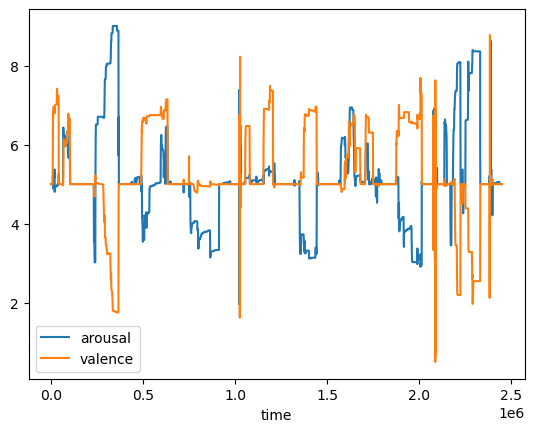

In [3]:
df1.plot(x="time", y=["arousal","valence"])
plt.show()

Leemos el csv de las variables Fisiológicas, y las representamos.

In [4]:
df2=pd.read_csv('Bruto/sub_10_physiological.csv')
df2=df2.rename(columns={"daqtime": "time"})
length_orig_df2=len(df2)
print(df2)

            time    ecg     bvp     gsr     rsp     skt  emg_zygo  emg_coru  \
0              0  1.096  35.865  35.677  33.292  27.535     8.439     8.686   
1              1  1.099  36.030  35.681  33.282  27.524     8.398     8.522   
2              2  1.102  36.195  35.684  33.273  27.514     8.356     8.358   
3              3  1.106  36.360  35.688  33.263  27.503     8.315     8.193   
4              4  1.106  36.457  35.681  33.263  27.507     8.193     8.151   
...          ...    ...     ...     ...     ...     ...       ...       ...   
2451579  2451579  0.902  35.698  25.879  34.502  25.298     5.275     7.945   
2451580  2451580  0.902  35.808  25.930  34.492  25.298     5.154     7.905   
2451581  2451581  0.902  35.934  25.911  34.521  25.295     5.193     7.985   
2451582  2451582  0.908  36.012  25.841  34.502  25.298     5.194     7.986   
2451583  2451583  0.899  35.840  25.852  34.502  25.298     5.234     7.946   

         emg_trap  video  
0          74.495     10

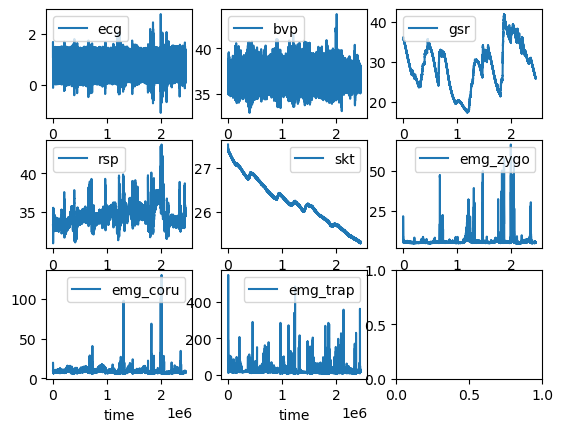

In [5]:
#define subplot layout
fig, axes = plt.subplots(nrows=3, ncols=3)

#add DataFrames to subplots
df2.plot(ax=axes[0,0],x="time",y="ecg")
df2.plot(ax=axes[0,1],x="time",y="bvp")
df2.plot(ax=axes[0,2],x="time",y="gsr")
df2.plot(ax=axes[1,0],x="time",y="rsp")
df2.plot(ax=axes[1,1],x="time",y="skt")
df2.plot(ax=axes[1,2],x="time",y="emg_zygo")
df2.plot(ax=axes[2,0],x="time",y="emg_coru")
df2.plot(ax=axes[2,1],x="time",y="emg_trap")
plt.show()

<AxesSubplot:xlabel='time'>

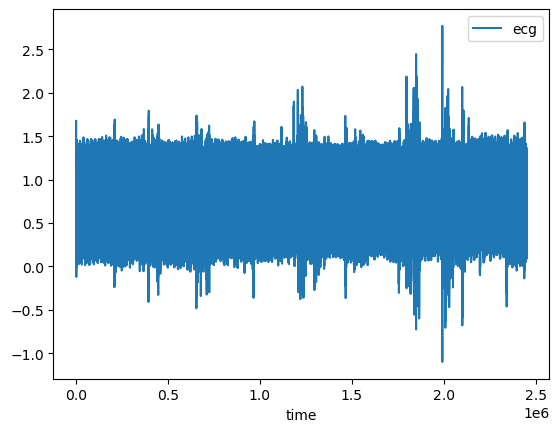

In [6]:
df2.plot(x="time",y="ecg")

<AxesSubplot:xlabel='time'>

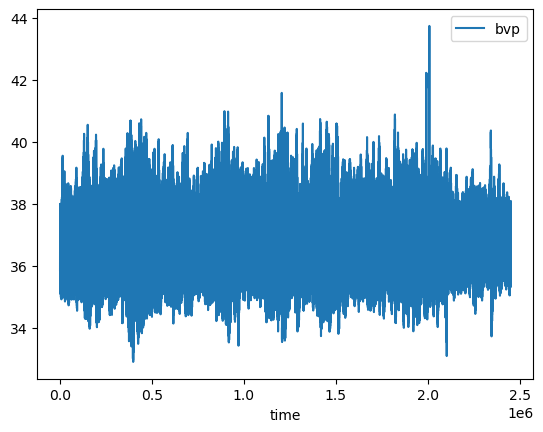

In [7]:
df2.plot(x="time",y="bvp")

<AxesSubplot:xlabel='time'>

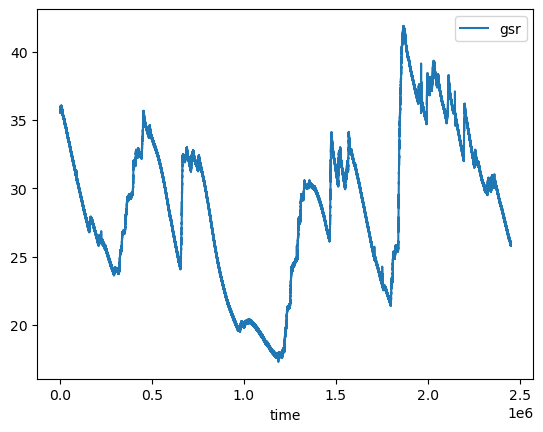

In [8]:
df2.plot(x="time",y="gsr")

<AxesSubplot:xlabel='time'>

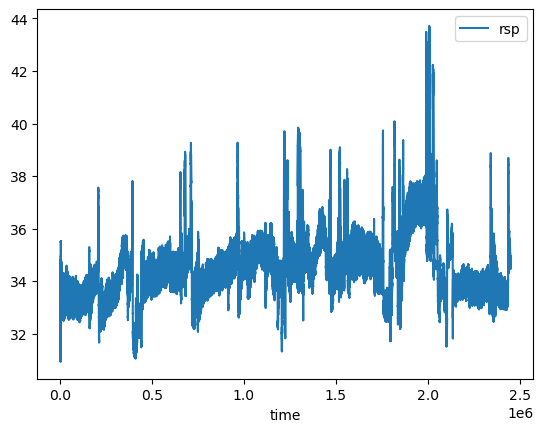

In [9]:
df2.plot(x="time",y="rsp")

<AxesSubplot:xlabel='time'>

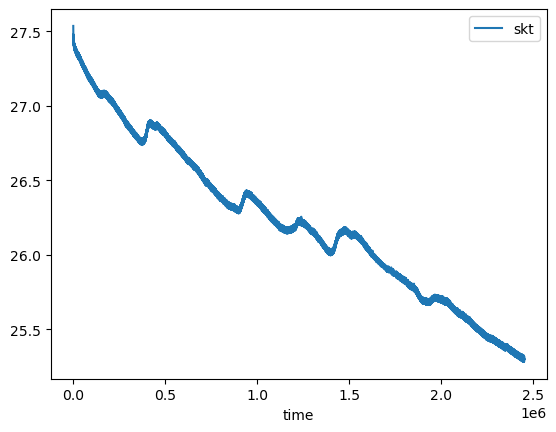

In [10]:
df2.plot(x="time",y="skt")


<AxesSubplot:xlabel='time'>

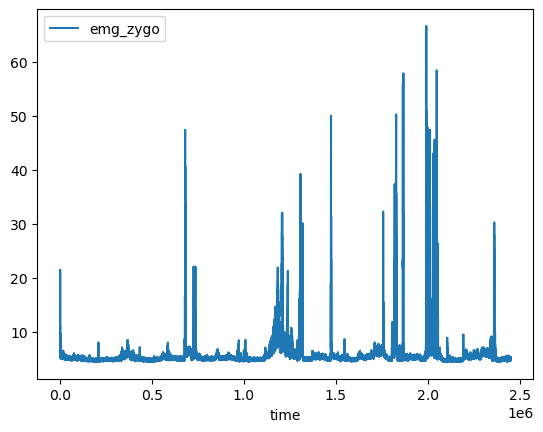

In [11]:
df2.plot(x="time",y="emg_zygo")


<AxesSubplot:xlabel='time'>

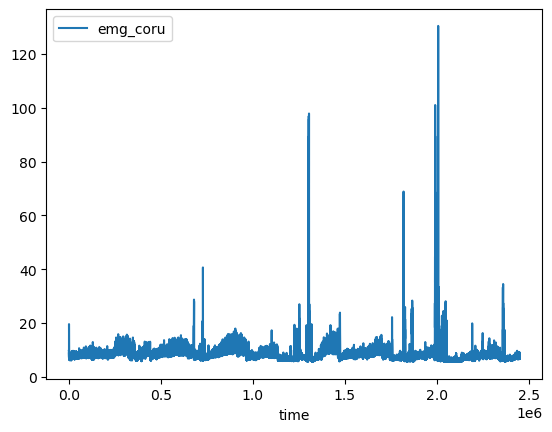

In [12]:
df2.plot(x="time",y="emg_coru")

<AxesSubplot:xlabel='time'>

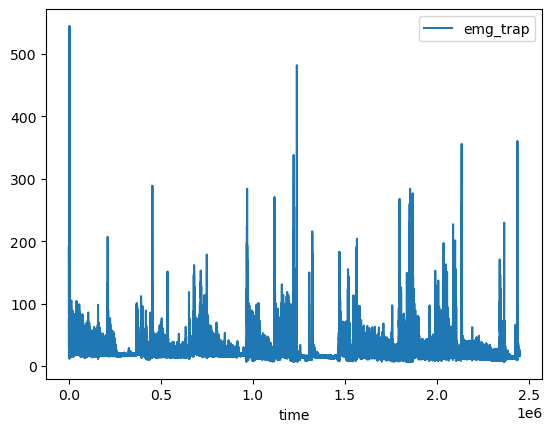

In [13]:
df2.plot(x="time",y="emg_trap")

El paper más completo que trata esto es CorrNet, donde se hace:

"Since the sampling rates of V-A and signals are 20 and 1000 Hz
respectively, we down-sampled all the signals to 50 Hz by decimation down-sampling. The EDA signals were
first filtered using a low pass filter with a 2 Hz cutoff frequency to remove noise.
For the BVP signal, we pre-processed it with a four-order butterworth bandpass filter with
cutoff frequencies [30, 200] Hz to eliminate the bursts. An elliptic band-pass filter
with cutoff frequencies [0.005, 0.1] was used to filter the ST signal. We followed the
standard filtering procedure widely used in previous works to pre-process the
physiological signals. Then the filtered signals are segmented into 2-second (sample size:
100 for CASE) instances."

O sea:

A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

D) Se normalizan las señales a 0 - 1, segun Min - Max.

E) Se busca la frecuencia en común de ambos a 50 Hz. Se hizo un estudio y fue la solución de compromiso.

F) Se utilizan ventanas de 2 segundos.

Lo vamos haciendo poco a poco.

    A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

<AxesSubplot:>

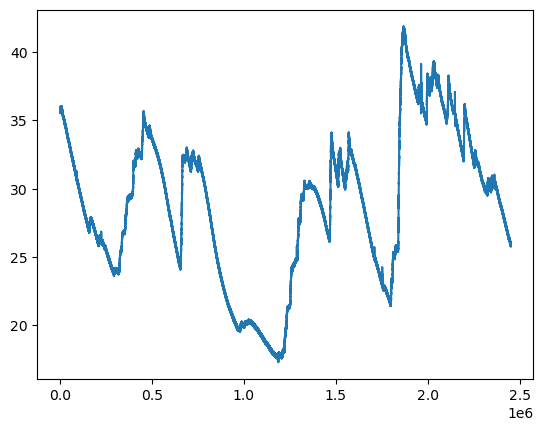

In [14]:
gsr_signal_notfiltered=df2['gsr']
gsr_signal_notfiltered.plot()

Representamos la senal en el dominio de la frecuencia. Vemos que hay frecuencias hasta el 500. Las querremos quitar todas menos las menores a 2 Hz. 

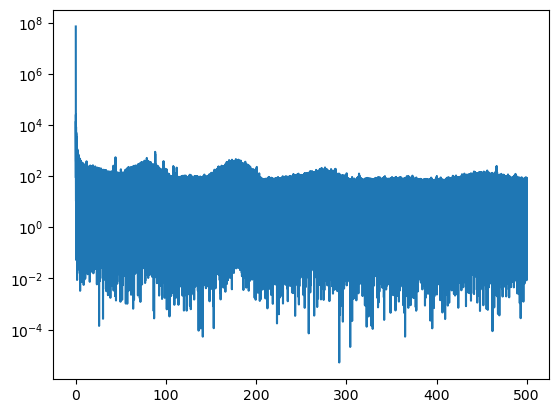

In [15]:
yf = rfft(gsr_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

In [16]:
lowpassfilter=signal.butter(N=10, Wn=2, btype='lp', fs=1000, output='sos')
gsr_filtered = signal.sosfilt(lowpassfilter, gsr_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias a partir de los 2 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente las frecuencias mayores a 2 Hz. 

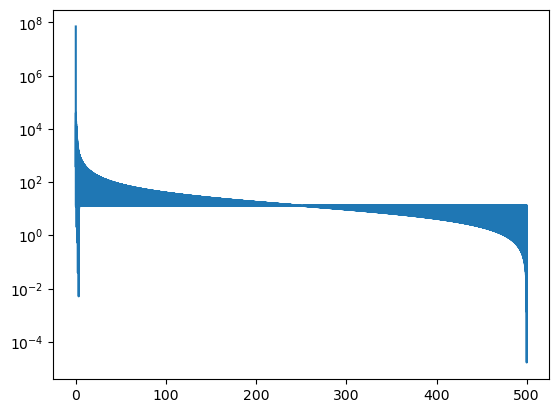

In [17]:
yf = rfft(gsr_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

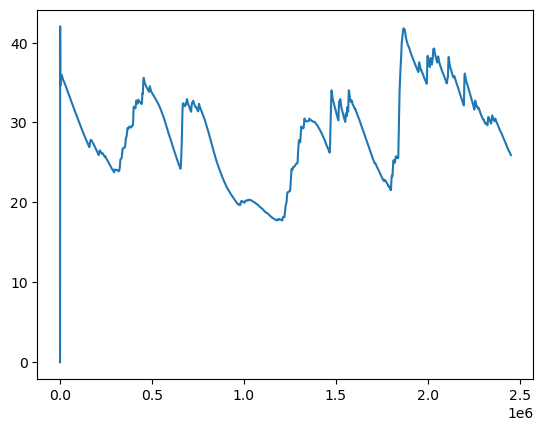

In [18]:
plt.plot(gsr_filtered)

In [19]:
gsr_signal_filtered = pd.DataFrame(gsr_filtered)
gsr_signal_filtered=gsr_signal_filtered.round(3)
gsr_signal_filtered=gsr_signal_filtered.rename(columns={0: "gsr"})
gsr_signal_filtered

gsr
0         0.000
1         0.000
2         0.000
3         0.000
4         0.000
...         ...
2451579  25.914
2451580  25.914
2451581  25.914
2451582  25.914
2451583  25.914

[2451584 rows x 1 columns]

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

<AxesSubplot:>

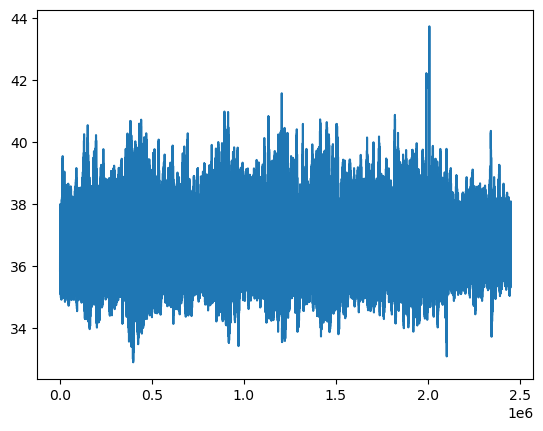

In [20]:
bvp_signal_notfiltered=df2['bvp']
bvp_signal_notfiltered.plot()

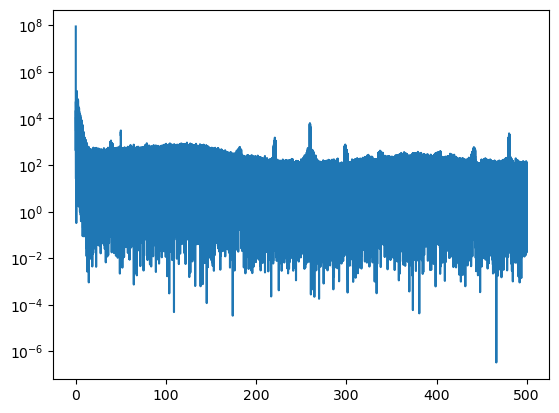

In [21]:
yf = rfft(bvp_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos el filtro Butter con frecuencias de corte de 30 a 200 Hz, de cuarto orden. Es un filtro paso banda.

In [22]:
butterfilter=signal.butter(N=4, Wn=[30,200], btype='bandpass', fs=1000, output='sos')
bvp_filtered = signal.sosfilt(butterfilter, bvp_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias menores de 30 Hz y mayores a 200 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente esas frecuencias.

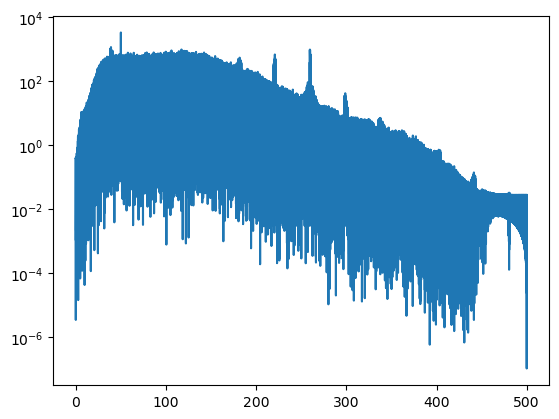

In [23]:
yf = rfft(bvp_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

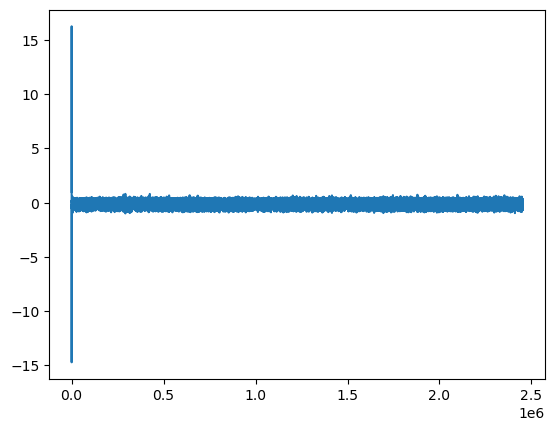

In [24]:
plt.plot(bvp_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [25]:
bvp_signal_filtered = pd.DataFrame(bvp_filtered)
bvp_signal_filtered=bvp_signal_filtered.round(3)
bvp_signal_filtered=bvp_signal_filtered.rename(columns={0: "bvp"})
bvp_signal_filtered=bvp_signal_filtered.add(37)
bvp_signal_filtered

bvp
0        37.997
1        42.564
2        50.111
3        53.264
4        46.209
...         ...
2451579  37.092
2451580  37.062
2451581  36.941
2451582  36.874
2451583  36.967

[2451584 rows x 1 columns]

    C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

<AxesSubplot:>

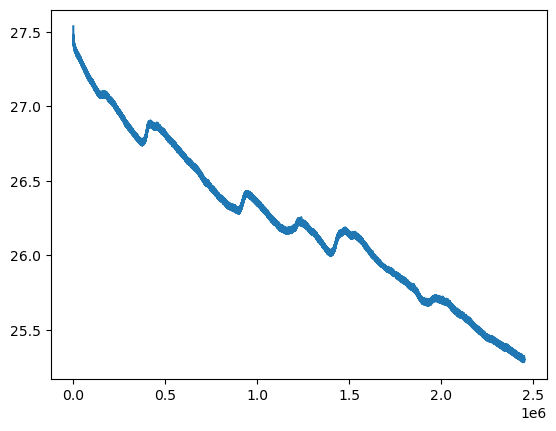

In [26]:
skt_signal_notfiltered=df2['skt']
skt_signal_notfiltered.plot()

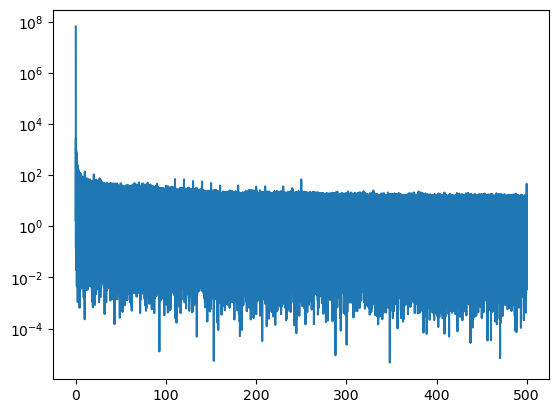

In [27]:
yf = rfft(skt_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos nuestro filtro eliptico con frecuencias corte [0.005, 0.1] a señal skt.

In [28]:
ellipticfilter=signal.ellip(N=4,rp=1, rs=1, Wn=[0.005,0.1], btype='bandpass', fs=1000, output='sos')
skt_filtered = signal.sosfilt(ellipticfilter, skt_signal_notfiltered)

Comprobamos la senal filtrada. Algo ha filtrado.

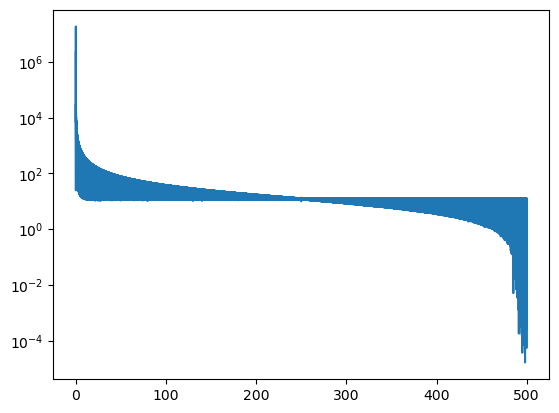

In [29]:
yf = rfft(skt_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

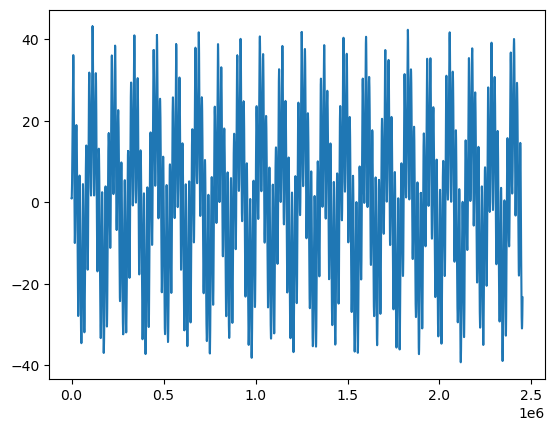

In [30]:
plt.plot(skt_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [31]:
skt_signal_filtered = pd.DataFrame(skt_filtered)
skt_signal_filtered=skt_signal_filtered.round(3)
skt_signal_filtered=skt_signal_filtered.rename(columns={0: "skt"})
skt_signal_filtered=skt_signal_filtered.add(40)
skt_signal_filtered

skt
0        40.882
1        40.882
2        40.882
3        40.881
4        40.882
...         ...
2451579  16.550
2451580  16.554
2451581  16.558
2451582  16.563
2451583  16.567

[2451584 rows x 1 columns]

D) Se normalizan las senales.

Antes de normalizarlas, vamos a borrar las primeras 5000, ya que por los filtrados los principios de las senales son un poco raros. Borramos las columnas que acabamos de tunear del dataframe con todo.

In [32]:
df2=df2.drop(columns=["skt","bvp","gsr"])
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video
0              0  1.096  33.292     8.439     8.686    74.495     10
1              1  1.099  33.282     8.398     8.522    72.605     10
2              2  1.102  33.273     8.356     8.358    70.716     10
3              3  1.106  33.263     8.315     8.193    68.827     10
4              4  1.106  33.263     8.193     8.151    67.223     10
...          ...    ...     ...       ...       ...       ...    ...
2451579  2451579  0.902  34.502     5.275     7.945    17.515     12
2451580  2451580  0.902  34.492     5.154     7.905    17.473     12
2451581  2451581  0.902  34.521     5.193     7.985    17.392     12
2451582  2451582  0.908  34.502     5.194     7.986    17.391     12
2451583  2451583  0.899  34.502     5.234     7.946    17.269     12

[2451584 rows x 7 columns]

In [33]:
df2=pd.concat([df2, bvp_signal_filtered, gsr_signal_filtered,skt_signal_filtered], axis=1)
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video     bvp  \
0              0  1.096  33.292     8.439     8.686    74.495     10  37.997   
1              1  1.099  33.282     8.398     8.522    72.605     10  42.564   
2              2  1.102  33.273     8.356     8.358    70.716     10  50.111   
3              3  1.106  33.263     8.315     8.193    68.827     10  53.264   
4              4  1.106  33.263     8.193     8.151    67.223     10  46.209   
...          ...    ...     ...       ...       ...       ...    ...     ...   
2451579  2451579  0.902  34.502     5.275     7.945    17.515     12  37.092   
2451580  2451580  0.902  34.492     5.154     7.905    17.473     12  37.062   
2451581  2451581  0.902  34.521     5.193     7.985    17.392     12  36.941   
2451582  2451582  0.908  34.502     5.194     7.986    17.391     12  36.874   
2451583  2451583  0.899  34.502     5.234     7.946    17.269     12  36.967   

            gsr     skt  
0         0.000  40.882  
1         0.000  40.882  
2         0.000  40.882  
3         0.000  40.881  
4         0.000  40.882  
...         ...     ...  
2451579  25.914  16.550  
2451580  25.914  16.554  
2451581  25.914  16.558  
2451582  25.914  16.563  
2451583  25.914  16.567  

[2451584 rows x 10 columns]

Tras aclarar esto, ya pasamos a normalizar. Antes, quitamos los videos que van al train, para que se normalicen solo los datos que van a ser entrenados realmente (sin los videos de BlueScreen, EndVid y StartVid).

In [34]:
df2 = df2[df2.video != 10]
df2 = df2[df2.video != 11]
df2 = df2[df2.video != 12]
scaler = MinMaxScaler()
scaler.fit(df2)
normalized = pd.DataFrame(scaler.transform(df2), index=df2.index, columns=df2.columns)
df2_normalized = pd.DataFrame(normalized, columns=df2.columns)
df2_normalized=df2_normalized.drop(columns=["video","time"])
numvideo_bien = df2["video"] 
tiempo_bien=df2["time"] 
df2_normalized=df2_normalized.join(numvideo_bien)
df2_normalized=df2_normalized.join(tiempo_bien)
df2=df2_normalized[["time","ecg","bvp","gsr","skt","rsp","emg_zygo","emg_coru","emg_trap","video"]]
df2

time       ecg       bvp       gsr       skt       rsp  emg_zygo  \
221501    221501  0.555613  0.557095  0.359251  0.792730  0.118680  0.005959   
221502    221502  0.555613  0.568182  0.359251  0.792653  0.118680  0.007263   
221503    221503  0.553026  0.579268  0.359251  0.792577  0.117924  0.006635   
221504    221504  0.551216  0.565965  0.359251  0.792487  0.117084  0.005315   
221505    221505  0.552250  0.548226  0.359251  0.792424  0.119520  0.006603   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.484221  0.519956  0.534863  0.356423  0.136570  0.020501   
2331580  2331580  0.487584  0.530488  0.534863  0.356512  0.136570  0.021161   
2331581  2331581  0.482411  0.528825  0.534863  0.356602  0.137410  0.019857   
2331582  2331582  0.484221  0.529379  0.534863  0.356678  0.135814  0.021161   
2331583  2331583  0.484997  0.563193  0.534863  0.356767  0.134974  0.020517   

         emg_coru  emg_trap  video  
221501   0.013162  0.066113      8  
221502   0.013490  0.066697      8  
221503   0.013819  0.068451      8  
221504   0.012520  0.071029      8  
221505   0.013482  0.075134      8  
...           ...       ...    ...  
2331579  0.018420  0.012945      7  
2331580  0.017450  0.012590      7  
2331581  0.017442  0.012120      7  
2331582  0.017771  0.011765      7  
2331583  0.016793  0.011298      7  

[1270083 rows x 10 columns]

    E) Frecuencia común 50 Hz

Para la frecuencia comun a ambos, ello implica tener lecturas cada 1/50 = 20 ms. Para las senales fisiologicas lo tenemos, pero para las annotations no, por lo que hay que resample. Primero resampleamos a que nos saque todos los valores por milisegundo de annotations, y luego downsampleamos para quedarnos solo con los que sean menores a 20 ms. 

In [35]:
n_samples=length_orig_df2
df1_clean=df1.drop(columns=['time', 'video'])
array1_resampled=signal.resample(df1_clean, n_samples)
df1_resampled=pd.DataFrame(array1_resampled,columns=["valence","arousal"])
df1_resampled=df1_resampled.round(3)
print(df1_resampled)

         valence  arousal
0            5.0      5.0
1            5.0      5.0
2            5.0      5.0
3            5.0      5.0
4            5.0      5.0
...          ...      ...
2451579      5.0      5.0
2451580      5.0      5.0
2451581      5.0      5.0
2451582      5.0      5.0
2451583      5.0      5.0

[2451584 rows x 2 columns]


Unimos los csv, con columna intersección en "time". Borramos los instantes de tiempo X e Y porque en realidad no son necesarios. Reordenamos las columnas.

In [36]:
df3=pd.merge(df1_resampled, df2, left_index=True, right_index=True)

columnsTitles = ['time', 'ecg', 'bvp','gsr','rsp','skt','emg_zygo','emg_coru','emg_trap','valence','arousal','video']
df3 = df3.reindex(columns=columnsTitles)

print(df3)

            time       ecg       bvp       gsr       rsp       skt  emg_zygo  \
221501    221501  0.555613  0.557095  0.359251  0.118680  0.792730  0.005959   
221502    221502  0.555613  0.568182  0.359251  0.118680  0.792653  0.007263   
221503    221503  0.553026  0.579268  0.359251  0.117924  0.792577  0.006635   
221504    221504  0.551216  0.565965  0.359251  0.117084  0.792487  0.005315   
221505    221505  0.552250  0.548226  0.359251  0.119520  0.792424  0.006603   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.484221  0.519956  0.534863  0.136570  0.356423  0.020501   
2331580  2331580  0.487584  0.530488  0.534863  0.136570  0.356512  0.021161   
2331581  2331581  0.482411  0.528825  0.534863  0.137410  0.356602  0.019857   
2331582  2331582  0.484221  0.529379  0.534863  0.135814  0.356678  0.021161   
2331583  2331583  0.484997  0.563193  0.534863  0.134974  0.356767  0.020517   

         emg_coru  emg_trap  valence  a

Downsampleamos a 20 ms y eliminamos la columna tiempo. 

In [37]:
df3 = df3.drop(df3[df3.time%20 != 0].index)
df3 = df3.drop(columns=['time'])
print(df3)

              ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
221520   0.500259  0.549889  0.359251  0.118680  0.791263  0.005991  0.012512   
221540   0.468960  0.690133  0.359209  0.122795  0.789732  0.006619  0.010853   
221560   0.458614  0.569290  0.359167  0.125987  0.788188  0.007279  0.016785   
221580   0.450078  0.552661  0.359167  0.126827  0.786631  0.005959  0.015807   
221600   0.456803  0.475055  0.359125  0.133294  0.785100  0.007263  0.019727   
...           ...       ...       ...       ...       ...       ...       ...   
2331500  0.501035  0.536585  0.535114  0.139006  0.349852  0.021194  0.031926   
2331520  0.477237  0.476718  0.535072  0.139006  0.351511  0.022482  0.029946   
2331540  0.471547  0.640798  0.534989  0.138250  0.353182  0.020501  0.026997   
2331560  0.475685  0.546009  0.534947  0.137410  0.354854  0.019197  0.022380   
2331580  0.487584  0.530488  0.534863  0.136570  0.356512  0.021161  0.017450   

         emg_trap  valence 

Creamos la ventana de n = 2 segundos. Una ventana de datos simplemente será concatenar los datos dentro de grupos de 2 segundos, haciendo la media de valencia y de arousal de todos ellos. 

Como la frecuencia de muestreo son 20 ms, cada ventana de 2 segundos tendrá en total 100 observaciones. Después, esto lo "flattenaremos" para que el modelo ML en R pueda tragarlo.  

En primer lugar, como las ventanas son de 2 segundos, eliminamos un número de datos para que nos den las ventanas justas. Tendríamos varios criterios:

- A) Ver en el completo de los datos las entradas que tenemos múltiplos de 100 (ventanas de 2 s), y eliminar del múltiplo más alto hasta el final.

- B) Algo más fino quizá sería hacer lo mismo pero video a video. 

Por simplicidad y ver lo que sale hacemos A). Comenzamos creando un nuevo indice desde 0 del Dataframe que tenemos y borramos el valor del video. 

In [38]:
df3 = df3.drop(columns=['video'])
df3 = df3.reset_index()
df3 = df3.drop(columns=['index'])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.500259  0.549889  0.359251  0.118680  0.791263  0.005991  0.012512   
1      0.468960  0.690133  0.359209  0.122795  0.789732  0.006619  0.010853   
2      0.458614  0.569290  0.359167  0.125987  0.788188  0.007279  0.016785   
3      0.450078  0.552661  0.359167  0.126827  0.786631  0.005959  0.015807   
4      0.456803  0.475055  0.359125  0.133294  0.785100  0.007263  0.019727   
...         ...       ...       ...       ...       ...       ...       ...   
63499  0.501035  0.536585  0.535114  0.139006  0.349852  0.021194  0.031926   
63500  0.477237  0.476718  0.535072  0.139006  0.351511  0.022482  0.029946   
63501  0.471547  0.640798  0.534989  0.138250  0.353182  0.020501  0.026997   
63502  0.475685  0.546009  0.534947  0.137410  0.354854  0.019197  0.022380   
63503  0.487584  0.530488  0.534863  0.136570  0.356512  0.021161  0.017450   

       emg_trap  valence  arousal  
0      0.079998    5.000    5.000  
1      0.127330    5.000    5.000  
2      0.084707    5.000    5.000  
3      0.059888    5.000    5.000  
4      0.042589    5.000    5.000  
...         ...      ...      ...  
63499  0.006116    2.542    8.362  
63500  0.039523    2.542    8.362  
63501  0.029411    2.543    8.360  
63502  0.021768    2.545    8.359  
63503  0.012590    2.543    8.360  

[63504 rows x 10 columns]

Como tenemos 63504 filas, necesitamos borrar solo las ultimas 4.

In [39]:
df3=df3.drop([63503, 63502, 63501, 63500])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.500259  0.549889  0.359251  0.118680  0.791263  0.005991  0.012512   
1      0.468960  0.690133  0.359209  0.122795  0.789732  0.006619  0.010853   
2      0.458614  0.569290  0.359167  0.125987  0.788188  0.007279  0.016785   
3      0.450078  0.552661  0.359167  0.126827  0.786631  0.005959  0.015807   
4      0.456803  0.475055  0.359125  0.133294  0.785100  0.007263  0.019727   
...         ...       ...       ...       ...       ...       ...       ...   
63495  0.493533  0.590355  0.535365  0.140685  0.343154  0.014575  0.026989   
63496  0.518107  0.531042  0.535281  0.140685  0.344825  0.016539  0.025345   
63497  0.520693  0.568182  0.535240  0.138250  0.346509  0.017860  0.025345   
63498  0.518107  0.568182  0.535198  0.139006  0.348181  0.018520  0.029281   
63499  0.501035  0.536585  0.535114  0.139006  0.349852  0.021194  0.031926   

       emg_trap  valence  arousal  
0      0.079998    5.000    5.000  
1      0.127330    5.000    5.000  
2      0.084707    5.000    5.000  
3      0.059888    5.000    5.000  
4      0.042589    5.000    5.000  
...         ...      ...      ...  
63495  0.016824    2.542    8.362  
63496  0.009296    2.543    8.361  
63497  0.006001    2.544    8.359  
63498  0.007291    2.543    8.361  
63499  0.006116    2.542    8.362  

[63500 rows x 10 columns]

Y ahora si, con split dividimos el Dataset en 635 entradas de 100 datos cada una. 

In [40]:
df3_split_2s = np.array_split(df3, len(df3)/25)
df3_split_2s

[         ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
 0   0.500259  0.549889  0.359251  0.118680  0.791263  0.005991  0.012512   
 1   0.468960  0.690133  0.359209  0.122795  0.789732  0.006619  0.010853   
 2   0.458614  0.569290  0.359167  0.125987  0.788188  0.007279  0.016785   
 3   0.450078  0.552661  0.359167  0.126827  0.786631  0.005959  0.015807   
 4   0.456803  0.475055  0.359125  0.133294  0.785100  0.007263  0.019727   
 5   0.454475  0.559867  0.359084  0.133294  0.783543  0.007923  0.017113   
 6   0.453440  0.517184  0.359042  0.134974  0.782000  0.007940  0.016119   
 7   0.451888  0.526608  0.359000  0.136570  0.780443  0.006619  0.022380   
 8   0.451888  0.572062  0.359000  0.142197  0.778886  0.007923  0.020063   
 9   0.445163  0.593681  0.358958  0.139845  0.777330  0.005331  0.025682   
 10  0.442576  0.527162  0.358916  0.143877  0.775773  0.005959  0.019759   
 11  0.441542  0.454545  0.358875  0.145557  0.774217  0.007279  0.017442   

Ahora, realizaremos el Flatteneado. Las matrices las haremos una linea continua: pasamos de tener 100 observaciones de 8 variables a tener 1 observacion de 800 variables. 
Creamos el Dataframe que nos contenga todo, que tendrá 800 variables + Valence + Arousal (802 en total). Le ponemos nombre a las columnas del Dataframe solamente porque no se puede crear un Dataframe sin columnas, sino solo nos importaría llamar a la de Valence y Arousal.  

In [41]:
list_array = list(np.arange(1,201))
list_array.append("valence")
list_array.append("arousal")
df4 = pd.DataFrame(columns=list_array)
df4

Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]
Index: []

[0 rows x 202 columns]

Y ahora hago el proceso de hacer el flatenning, y obtener el nuevo Dataframe con la ventana aplicada que exportaremos. Lo hacemos con un for para que repase todas las agrupaciones de 8 x 100 datos. De cada ventana calculamos (según papers) la valence y arousal promedios, y eso lo anadiremos en las ultimas dos columnas). 

In [42]:
for entrada in df3_split_2s:
    ave_valence=entrada['valence'].mean()
    ave_arousal=entrada['arousal'].mean()
    entrada=entrada.drop(columns=['valence','arousal'])
    a=entrada.to_numpy().flatten()
    a=np.append(a, ave_valence)
    a=np.append(a, ave_arousal)
    df4.loc[len(df4)] = a

In [43]:
df4

1         2         3         4         5         6         7  \
0     0.500259  0.549889  0.359251  0.118680  0.791263  0.005991  0.012512   
1     0.461200  0.575942  0.358331  0.164287  0.752246  0.006619  0.020071   
2     0.427056  0.546563  0.357412  0.136654  0.712986  0.004670  0.030299   
3     0.490947  0.531596  0.356283  0.082059  0.674837  0.004654  0.023702   
4     0.505432  0.560976  0.355238  0.052831  0.638907  0.006635  0.023045   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.524056  0.557095  0.541175  0.139845  0.164132  0.019841  0.024680   
2536  0.502845  0.557650  0.540674  0.185369  0.194473  0.015879  0.032239   
2537  0.432230  0.530488  0.539796  0.210566  0.229611  0.021178  0.030283   
2538  0.496896  0.531042  0.538291  0.199143  0.268437  0.023819  0.028624   
2539  0.643818  0.502772  0.536870  0.161011  0.309610  0.015895  0.034563   

             8         9        10  ...       193       194       195  \
0     0.079998  0.468960  0.690133  ...  0.309105  0.583703  0.358373   
1     0.099288  0.473875  0.564856  ...  0.418003  0.560976  0.357453   
2     0.047410  0.445163  0.585366  ...  0.512157  0.588137  0.356325   
3     0.085762  0.483187  0.556541  ...  0.426280  0.547118  0.355280   
4     0.028002  0.512157  0.542129  ...  0.493533  0.578714  0.354360   
...        ...       ...       ...  ...       ...       ...       ...   
2535  0.037421  0.513192  0.522727  ...  0.503621  0.528825  0.540716   
2536  0.013298  0.514744  0.544346  ...  0.555872  0.569845  0.539880   
2537  0.039649  0.521469  0.613082  ...  0.501035  0.512195  0.538333   
2538  0.015412  0.492757  0.580377  ...  0.624418  0.520510  0.536953   
2539  0.019296  0.643042  0.615854  ...  0.501035  0.536585  0.535114   

           196       197       198       199       200  valence  arousal  
0     0.165043  0.753815  0.006619  0.021722  0.073034  5.00000  5.00000  
1     0.142281  0.714543  0.005959  0.032568  0.070367  5.00000  5.00000  
2     0.082899  0.676329  0.004654  0.026660  0.061999  5.00000  5.00000  
3     0.055266  0.640298  0.007279  0.022051  0.044012  5.00000  5.00000  
4     0.033345  0.607354  0.005959  0.022059  0.121885  5.00000  5.00000  
...        ...       ...       ...       ...       ...      ...      ...  
2535  0.184529  0.193159  0.018520  0.038515  0.027417  2.54300  8.36080  
2536  0.213002  0.228118  0.020517  0.021394  0.017749  2.54316  8.36112  
2537  0.199227  0.266829  0.021838  0.021730  0.028357  2.54284  8.36120  
2538  0.162607  0.307939  0.015879  0.034571  0.031299  2.54280  8.36120  
2539  0.139006  0.349852  0.021194  0.031926  0.006116  2.54280  8.36116  

[2540 rows x 202 columns]

Para esta iteracion, analizamos los datos segun CorrNet. CorrNet propone 3 clasificaciones diferentes:
- Clasificación en 2 clases:
    
    Modelo ML A: Clasificamos Arousal en High y Low.
    
    Modelo ML B: Clasificamos Valence en High y Low. 


- Clasificación en 3 clases:
    
    Modelo ML C: Clasificamos Arousal en High, Neutral y Low.
   
    Modelo ML D: Clasificamos Valence en High, Neutral y Low.
    
    
- Clasificación en 4 clases:
    
    Modelo ML E: Clasificamos Valence y Arousal en los cuatro cuadrantes: High High, High Low, Low Low y Low High. 
   
   
Para cada uno, realizamos un dataframe diferente. 

- Modelo A. Clasificamos Arousal en High y Low. High --> 2 y Low --> 1

In [44]:
df4_A = df4.drop(columns=['valence'])
df4_A=df4_A.rename(columns={"arousal": "auxiliar"})
df4_A.loc[df4_A['auxiliar'] < 5, 'arousal'] = 1
df4_A.loc[df4_A['auxiliar'] >= 5, 'arousal'] = 2
df4_A = df4_A.drop(columns=['auxiliar'])
print(df4_A)

             1         2         3         4         5         6         7  \
0     0.500259  0.549889  0.359251  0.118680  0.791263  0.005991  0.012512   
1     0.461200  0.575942  0.358331  0.164287  0.752246  0.006619  0.020071   
2     0.427056  0.546563  0.357412  0.136654  0.712986  0.004670  0.030299   
3     0.490947  0.531596  0.356283  0.082059  0.674837  0.004654  0.023702   
4     0.505432  0.560976  0.355238  0.052831  0.638907  0.006635  0.023045   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.524056  0.557095  0.541175  0.139845  0.164132  0.019841  0.024680   
2536  0.502845  0.557650  0.540674  0.185369  0.194473  0.015879  0.032239   
2537  0.432230  0.530488  0.539796  0.210566  0.229611  0.021178  0.030283   
2538  0.496896  0.531042  0.538291  0.199143  0.268437  0.023819  0.028624   
2539  0.643818  0.502772  0.536870  0.161011  0.309610  0.015895  0.034563   

             8         9        10  ...       192       193    

In [45]:
df4_A.to_csv('Output/arousal_2_clases_sub10.csv', index=False)

- Modelo B. Clasificamos Valence en High y Low. High --> 2 y Low --> 1

In [46]:
df4_B = df4.drop(columns=['arousal'])
df4_B=df4_B.rename(columns={"valence": "auxiliar"})
df4_B.loc[df4_B['auxiliar'] < 5, 'valence'] = 1
df4_B.loc[df4_B['auxiliar'] >= 5, 'valence'] = 2
df4_B = df4_B.drop(columns=['auxiliar'])
print(df4_B)

             1         2         3         4         5         6         7  \
0     0.500259  0.549889  0.359251  0.118680  0.791263  0.005991  0.012512   
1     0.461200  0.575942  0.358331  0.164287  0.752246  0.006619  0.020071   
2     0.427056  0.546563  0.357412  0.136654  0.712986  0.004670  0.030299   
3     0.490947  0.531596  0.356283  0.082059  0.674837  0.004654  0.023702   
4     0.505432  0.560976  0.355238  0.052831  0.638907  0.006635  0.023045   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.524056  0.557095  0.541175  0.139845  0.164132  0.019841  0.024680   
2536  0.502845  0.557650  0.540674  0.185369  0.194473  0.015879  0.032239   
2537  0.432230  0.530488  0.539796  0.210566  0.229611  0.021178  0.030283   
2538  0.496896  0.531042  0.538291  0.199143  0.268437  0.023819  0.028624   
2539  0.643818  0.502772  0.536870  0.161011  0.309610  0.015895  0.034563   

             8         9        10  ...       192       193    

In [47]:
df4_B.to_csv('Output/valence_2_clases_sub10.csv', index=False)

- Modelo C. Clasificamos Arousal en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [48]:
df4_C = df4.drop(columns=['valence'])
df4_C=df4_C.rename(columns={"arousal": "auxiliar"})
df4_C.loc[df4_C['auxiliar'] < 3, 'arousal'] = 1
df4_C.loc[(df4_C['auxiliar'] >= 3) & (df4_C['auxiliar'] < 6), 'arousal'] = 2
df4_C.loc[(df4_C['auxiliar'] >= 6), 'arousal'] = 3
df4_C = df4_C.drop(columns=['auxiliar'])
print(df4_C)

             1         2         3         4         5         6         7  \
0     0.500259  0.549889  0.359251  0.118680  0.791263  0.005991  0.012512   
1     0.461200  0.575942  0.358331  0.164287  0.752246  0.006619  0.020071   
2     0.427056  0.546563  0.357412  0.136654  0.712986  0.004670  0.030299   
3     0.490947  0.531596  0.356283  0.082059  0.674837  0.004654  0.023702   
4     0.505432  0.560976  0.355238  0.052831  0.638907  0.006635  0.023045   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.524056  0.557095  0.541175  0.139845  0.164132  0.019841  0.024680   
2536  0.502845  0.557650  0.540674  0.185369  0.194473  0.015879  0.032239   
2537  0.432230  0.530488  0.539796  0.210566  0.229611  0.021178  0.030283   
2538  0.496896  0.531042  0.538291  0.199143  0.268437  0.023819  0.028624   
2539  0.643818  0.502772  0.536870  0.161011  0.309610  0.015895  0.034563   

             8         9        10  ...       192       193    

In [49]:
df4_C.to_csv('Output/arousal_3_clases_sub10.csv', index=False)

- Modelo D. Clasificamos Valence en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [50]:
df4_D = df4.drop(columns=['arousal'])
df4_D=df4_D.rename(columns={"valence": "auxiliar"})
df4_D.loc[df4_D['auxiliar'] < 3, 'valence'] = 1
df4_D.loc[(df4_D['auxiliar'] >= 3) & (df4_D['auxiliar'] < 6), 'valence'] = 2
df4_D.loc[(df4_D['auxiliar'] >= 6), 'valence'] = 3
df4_D = df4_D.drop(columns=['auxiliar'])
print(df4_D)

             1         2         3         4         5         6         7  \
0     0.500259  0.549889  0.359251  0.118680  0.791263  0.005991  0.012512   
1     0.461200  0.575942  0.358331  0.164287  0.752246  0.006619  0.020071   
2     0.427056  0.546563  0.357412  0.136654  0.712986  0.004670  0.030299   
3     0.490947  0.531596  0.356283  0.082059  0.674837  0.004654  0.023702   
4     0.505432  0.560976  0.355238  0.052831  0.638907  0.006635  0.023045   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.524056  0.557095  0.541175  0.139845  0.164132  0.019841  0.024680   
2536  0.502845  0.557650  0.540674  0.185369  0.194473  0.015879  0.032239   
2537  0.432230  0.530488  0.539796  0.210566  0.229611  0.021178  0.030283   
2538  0.496896  0.531042  0.538291  0.199143  0.268437  0.023819  0.028624   
2539  0.643818  0.502772  0.536870  0.161011  0.309610  0.015895  0.034563   

             8         9        10  ...       192       193    

In [51]:
df4_D.to_csv('Output/valence_3_clases_sub10.csv', index=False)

- Modelo E. Clasificamos Valence y Arousal. Valence High y Arousal High --> 4, Valence High y Arousal Low --> 3, Valence Low y Arousal High --> 2, Valence Low y Arousal Low --> 1. 

In [52]:
df4_E = df4
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 1
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 2
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 3
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 4
df4_E = df4_E.drop(columns=['valence', 'arousal'])
print(df4_E)

             1         2         3         4         5         6         7  \
0     0.500259  0.549889  0.359251  0.118680  0.791263  0.005991  0.012512   
1     0.461200  0.575942  0.358331  0.164287  0.752246  0.006619  0.020071   
2     0.427056  0.546563  0.357412  0.136654  0.712986  0.004670  0.030299   
3     0.490947  0.531596  0.356283  0.082059  0.674837  0.004654  0.023702   
4     0.505432  0.560976  0.355238  0.052831  0.638907  0.006635  0.023045   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.524056  0.557095  0.541175  0.139845  0.164132  0.019841  0.024680   
2536  0.502845  0.557650  0.540674  0.185369  0.194473  0.015879  0.032239   
2537  0.432230  0.530488  0.539796  0.210566  0.229611  0.021178  0.030283   
2538  0.496896  0.531042  0.538291  0.199143  0.268437  0.023819  0.028624   
2539  0.643818  0.502772  0.536870  0.161011  0.309610  0.015895  0.034563   

             8         9        10  ...       192       193    

In [53]:
df4_E.to_csv('Output/valencearousal_4_clases_sub10.csv', index=False)